<a href="https://colab.research.google.com/github/PinakW/DIssertation_expt/blob/main/Original_CadenceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
#For plotting the dataset
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
#Data pipeline preparation
import tensorflow as tf
from tensorflow.keras import layers
#model buildingZ
from tensorflow.keras import models
import tensorflow.keras.utils as tfutils
import os

In [ ]:
NUM_CLASSES = 10
USE_ORIGINAL = 0

DataSet = 'caltech101'
#'cifar10'
def num_samples_per_class(ds_train, get_top_10 = False, print_all = False):
    vals = np.unique(np.fromiter(ds_train.map(lambda x, y: y), int), return_counts=True)
    class_list = []
    class_hist = []
    for val,count in zip(*vals):
        if print_all==True:
            print(int(val), count)
        class_hist.append((val,count))
    if get_top_10 == True:
        sorted_tuple = sorted(class_hist, key=lambda t: t[-1], reverse=True)[:(NUM_CLASSES + 1)]    #+1 because we are going to remove "backround_google" i.e. 4
        class_list = [x for x,y in sorted_tuple]
    return class_list

def filter_fn(x, allowed_classes:list):
    allowed_classes = tf.constant(allowed_classes)
    isallowed = tf.equal(allowed_classes, tf.cast(x, allowed_classes.dtype))
    reduced_sum = tf.reduce_sum(tf.cast(isallowed, tf.float32))
    return tf.greater(reduced_sum, tf.constant(0.))

In [ ]:
#ds_train = tfds.load(DataSet, split='train + test[:75%]', as_supervised=True)
ds_train = tfds.load(DataSet, split='train + test[:75%]', as_supervised=True)
ds_test = tfds.load(DataSet, split='test', as_supervised=True)

In [ ]:
class_list = num_samples_per_class(ds_train, get_top_10=True)
if DataSet == 'caltech101':
  display(class_list)
  class_list = [i for i in class_list if i != 4]
  display(class_list)
  class_list.sort()

[66, 1, 4, 38, 37, 95, 57, 9, 16, 54, 20]

[66, 1, 38, 37, 95, 57, 9, 16, 54, 20]

In [ ]:
resized_ds_train = ds_train.filter(lambda x, y: filter_fn(y, class_list)) # as_supervised
resized_ds_test = ds_test.filter(lambda x, y: filter_fn(y, class_list))

In [ ]:
num_samples_per_class(resized_ds_train, print_all=True)

1 611
9 104
16 101
20 87
37 335
38 337
54 92
57 155
66 625
95 192


[]

In [ ]:
num_samples_per_class(resized_ds_test, print_all=True)

1 770
9 98
16 93
20 77
37 405
38 405
54 84
57 170
66 768
95 209


[]

In [ ]:
#Hyperparameters
IMG_SIZE = 60
NUM_CHANNELS = 3
BATCH_SIZE=128

input_shape = (IMG_SIZE,IMG_SIZE,NUM_CHANNELS)
#Relabelling to avoid issues. Note that human readability is reduced by this
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(class_list, dtype=tf.int64),
        #values=tf.constant([tfutils.to_categorical(0, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(1, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(2, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(3, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(4, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(5, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(6, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(7, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(8, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(9, num_classes=NUM_CLASSES, dtype=np.int64)],  dtype=tf.int64),
        values=tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  dtype=tf.int64)
    ),
    default_value= tf.constant(0,  dtype=tf.int64)
)

#This function will be used in the graph execution hence @tf.function prefix
@tf.function
def map_func(label):
    global class_list
    mapped_label = table.lookup(label)
    #print(type(mapped_label))
    #mapped_label = tf.keras.utils.to_categorical(tf.make_ndarray(mapped_label), num_classes=NUM_CLASSES)
    mapped_label = tf.one_hot(indices=mapped_label, depth=NUM_CLASSES)
    print("Label = " + str(label) + "\t" + "Mapped Label = " + str(mapped_label))
    return mapped_label

#Preprocessing done as part of the graph
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

resize_layer = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

buffer_size = 30*NUM_CLASSES

#Preprocessing function which invokes above graphs
def prepare(ds, shuffle=False, augment=False, resize_only = False):
    global buffer_size
    global BATCH_SIZE
    

    # Resize and rescale all datasets.
    if resize_only==True:
        ds = ds.map(lambda x, y: (resize_layer(x), map_func(y)), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (resize_and_rescale(x), map_func(y)), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(buffer_size)
        
    # Batch all datasets.
    #ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set.
    if augment:
        #f_ds = ds.filter(lambda x, y: filter_fn(y, [2,3,6]))    #[2,3,6] are the examples with lesser data. We are trying to bring back balance
        #f_ds_aug = f_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        #ds = ds.concatenate(f_ds_aug)
        #ds_aug = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        #ds = ds.concatenate(ds_aug)
        ds_aug = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.concatenate(ds_aug)

        
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resized_ds_train = prepare(resized_ds_train, augment=True)
resized_ds_test = prepare(resized_ds_test)

Label = Tensor("label:0", shape=(), dtype=int64)	Mapped Label = Tensor("one_hot:0", shape=(10,), dtype=float32)


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)>

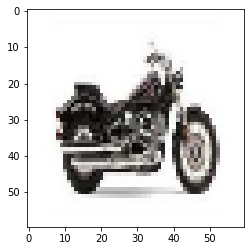

In [ ]:
for example in resized_ds_train.take(1):
  plt.imshow(example[0])
  display((example[-1]))

In [ ]:
#num_samples_per_class(resized_ds_test, print_all=True)

In [ ]:
#reg = tf.keras.regularizers.L2(0.01)
reg = tf.keras.regularizers.L1L2(l1 =0.01, l2 = 0.1)
#beta_regularizer = 0.1
#gamma_regularizer = 0.1

model = models.Sequential()

if USE_ORIGINAL == 1:
  	
	kernel_size = (5,5)
	model.add(layers.Conv2D(64, kernel_size, input_shape = input_shape, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())
	model.add(layers.ReLU())
	pool_size = (2,2)
	model.add(layers.MaxPool2D(pool_size))
	model.add(layers.Dropout(.2))
	
	kernel_size = (3,3)
	model.add(layers.Conv2D(192, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())                                                      #beta_regularizer = beta_regularizer, gamma_regularizer = gamma_regularizer
	model.add(layers.ReLU())
	pool_size = (2,2)
	model.add(layers.MaxPool2D(pool_size))
	model.add(layers.Dropout(.2))
	#model.add(layers.SpatialDropout2D(0.2))
	
	kernel_size = (3,3)
	model.add(layers.Conv2D(64, kernel_size, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())
	model.add(layers.ReLU())
	model.add(layers.Dropout(.2))
	
	kernel_size = (3,3)
	model.add(layers.Conv2D(128, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())
	model.add(layers.ReLU())
	pool_size = (2,2)
	model.add(layers.MaxPool2D(pool_size))
	model.add(layers.Dropout(.2))
	#model.add(layers.SpatialDropout2D(0.2))
	
	model.add(layers.Flatten())
	model.add(layers.Dropout(.2))
	model.add(layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer = reg))
else:
  kernel_size = (5,5)
  model.add(layers.Conv2D(32, kernel_size, input_shape = input_shape, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())
#  model.add(layers.ReLU())
	pool_size = (2,2)
	model.add(layers.MaxPool2D(pool_size))
	
	kernel_size = (3,3)
	model.add(layers.Conv2D(64, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())
#  model.add(layers.ReLU())
	pool_size = (2,2)
	model.add(layers.MaxPool2D(pool_size))
	
	kernel_size = (3,3)
	model.add(layers.Conv2D(128, kernel_size, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())
#  model.add(layers.ReLU())
	pool_size = (2,2)
	model.add(layers.MaxPool2D(pool_size))
	
	kernel_size = (3,3)
	model.add(layers.Conv2D(192, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())
#  model.add(layers.ReLU())
	pool_size = (2,2)
	model.add(layers.MaxPool2D(pool_size))
	
	kernel_size = (3,3)
	model.add(layers.Conv2D(64, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())
#  model.add(layers.ReLU())
	pool_size = (2,2)
	model.add(layers.MaxPool2D(pool_size))
	
	kernel_size = (3,3)
	model.add(layers.Conv2D(32, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
	model.add(layers.BatchNormalization())
#  model.add(layers.ReLU())
	pool_size = (2,2)
	model.add(layers.MaxPool2D(pool_size))
	
	model.add(layers.Flatten())
	model.add(layers.Dropout(.2))
	model.add(layers.Dense(1000, kernel_regularizer = reg))
	model.add(layers.Dropout(.02))
	model.add(layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer = reg))

In [ ]:
Learning_Rate = 1e-5                                           
opt = tf.keras.optimizers.Adam(learning_rate=Learning_Rate)     #OR tf.keras.optimizers.SGD(learning_rate=Learning_Rate, momentum=0.0)
#model.compile( optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'] )
model.compile( optimizer = opt, loss = 'categorical_crossentropy', metrics=['categorical_accuracy'] )


model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 60, 60, 64)        4864      
                                                                 
 batch_normalization_28 (Bat  (None, 60, 60, 64)       256       
 chNormalization)                                                
                                                                 
 re_lu_28 (ReLU)             (None, 60, 60, 64)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 30, 30, 64)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 30, 30, 192)     

In [ ]:
#h = model.fit( resized_ds_train, epochs=10)
resized_ds_train = resized_ds_train.batch(BATCH_SIZE)
resized_ds_test = resized_ds_test.batch(BATCH_SIZE)

h = model.fit( resized_ds_train, epochs=20, validation_data = resized_ds_test)

Epoch 1/20
42/42 [==============================] - 8s 162ms/step - loss: 122.0017 - categorical_accuracy: 0.1747 - val_loss: 120.6249 - val_categorical_accuracy: 0.3293
Epoch 2/20
42/42 [==============================] - 6s 151ms/step - loss: 120.2942 - categorical_accuracy: 0.2730 - val_loss: 119.3555 - val_categorical_accuracy: 0.2475
Epoch 3/20
42/42 [==============================] - 6s 151ms/step - loss: 118.8379 - categorical_accuracy: 0.3299 - val_loss: 118.0750 - val_categorical_accuracy: 0.2498
Epoch 4/20
42/42 [==============================] - 6s 151ms/step - loss: 117.4226 - categorical_accuracy: 0.3611 - val_loss: 116.7996 - val_categorical_accuracy: 0.2498
Epoch 5/20
42/42 [==============================] - 6s 153ms/step - loss: 116.0180 - categorical_accuracy: 0.3876 - val_loss: 115.5234 - val_categorical_accuracy: 0.2494
Epoch 6/20
42/42 [==============================] - 6s 154ms/step - loss: 114.6120 - categorical_accuracy: 0.4159 - val_loss: 114.2192 - val_categoric

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def ret_as_numpy():
    test = tfds.load(DataSet, split='test', as_supervised=True)
    test = prepare(test)
    test = tfds.as_numpy(test)
    return test

In [ ]:
test_as_np = ret_as_numpy()

In [ ]:
def evaluate_float_model(model, test):
    test_labels = []
    
    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_example in enumerate(test):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        test_labels.append(test_example[-1])
        test_image = test_example[0]
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        #display(test_image.shape)
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        #test_image = np.expand_dims(test_image, axis=3).astype(np.float32)
        #display(test_image.shape)
        
        # Run inference.
        output = model(test_image, training=False)
        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = output.numpy()
        #display(output[0])
        digit = np.argmax(output[0])
        prediction_digits.append(digit)
        
    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    #display(prediction_digits)
    #display(test_labels)
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [ ]:
test_accuracy_Float = evaluate_float_model(model, test_as_np)

print('Float test_accuracy:', test_accuracy_Float)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.




<ipython-input-177-233a3bd68f0e>:32: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = (prediction_digits == test_labels).mean()


AttributeError: ignored

Float checkpoint

In [ ]:
! pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
quantize_model = tfmot.quantization.keras.quantize_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 4.6 MB/s eta 0:00:00


In [ ]:
q_aware_model = quantize_model(model)
q_aware_model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
q_aware_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 60, 60, 3)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 60, 60, 64)       4993      
 erV2)                                                           
                                                                 
 quant_batch_normalization (  (None, 60, 60, 64)       257       
 QuantizeWrapperV2)                                              
                                                                 
 quant_re_lu (QuantizeWrappe  (None, 60, 60, 64)       3         
 rV2)                                                            
                                                                 
 quant_max_pooling2d (Quanti  (None, 30, 30, 64)      

In [ ]:
quantize_train, quant_train_info = tfds.load(DataSet, split='train + test[:75%]', with_info=True, as_supervised=True)
filtered_quantize_train = quantize_train.filter(lambda x, y: filter_fn(y, class_list))

resized_quantize_train = prepare(filtered_quantize_train)

In [ ]:
resized_quantize_train = resized_quantize_train.batch(BATCH_SIZE)
h = q_aware_model.fit(resized_quantize_train, epochs=5, validation_data = resized_ds_test)

Epoch 1/5
23/23 [==============================] - 11s 410ms/step - loss: 103.5816 - accuracy: 0.7253 - val_loss: 102.2401 - val_accuracy: 0.5522
Epoch 2/5
23/23 [==============================] - 6s 274ms/step - loss: 100.2163 - accuracy: 0.7621 - val_loss: 99.2292 - val_accuracy: 0.6013
Epoch 3/5
23/23 [==============================] - 6s 249ms/step - loss: 97.5099 - accuracy: 0.7906 - val_loss: 96.7705 - val_accuracy: 0.6351
Epoch 4/5
23/23 [==============================] - 6s 245ms/step - loss: 95.2851 - accuracy: 0.8003 - val_loss: 94.6298 - val_accuracy: 0.6976
Epoch 5/5
23/23 [==============================] - 4s 163ms/step - loss: 93.3335 - accuracy: 0.8161 - val_loss: 92.7477 - val_accuracy: 0.7188


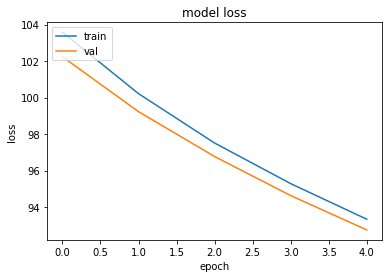

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
def evaluate_model(interpreter, test):
    test_labels = []


    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_example in enumerate(test):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        test_labels.append(test_example[-1])
        test_image = test_example[0]
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        #display(test_image.shape)
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        #test_image = np.expand_dims(test_image, axis=3).astype(np.float32)
        #display(test_image.shape)
        interpreter.set_tensor(input_index, test_image)
        
        # Run inference.
        interpreter.invoke()
        
        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        
    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [ ]:
#Models obtained from TfLiteConverter can be run in Python with Interpreter.
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
#Since TensorFlow Lite pre-plans tensor allocations to optimize inference, the user needs to call allocate_tensors() before any inference.
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter, test_as_np)

print('Quant TFLite test_accuracy:', test_accuracy)
#print('Quant TF test accuracy:', q_aware_model_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.


Quant TFLite test_accuracy: 0.5698553583168968


In [ ]:
MODEL_DIR = "CadenceNet_Float"
model.save(MODEL_DIR, save_format="tf")

In [ ]:
!pip install -U tf2onnx
!python -m tf2onnx.convert --saved-model /content/CadenceNet_Float/ --output /content/CadenceNetOriginal_Float.onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/442.3 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
ERROR: Operation cancelled by user
/usr/bin/python3: Error while finding module specification for 'tf2onnx.convert' (ModuleNotFoundError: No module named 'tf2onnx')


In [ ]:
quant_file = "/content/CadenceNetOriginal_QAT.tflite"
open(quant_file, "wb").write(quantized_tflite_model)

381680

In [ ]:

print("Float model in Mb: ", os.path.getsize("/content/CadenceNetOriginal_Float.onnx") / float(2**20))
print("Quantized model in Mb: ", os.path.getsize(quant_file) / float(2**20))
print("Float Model Accuracy: ", test_accuracy_Float)
print("Quantized Model Accuracy: ", test_accuracy)

FileNotFoundError: ignored

In [ ]:
indices = [0, 1, 2]
depth = 3
label = tf.one_hot(indices, depth)
print(str(label))

tf.Tensor(
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(3, 3), dtype=float32)
